# Source finding demo

## Initialisation

### imports:

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from astropy.io import fits
from numba import njit
from photutils import segmentation as segm
from scipy import stats

## Read data

Please *choose one* of the following:

### images:

In [2]:
hdu = fits.open('data/CIG_335.fits')
data = hdu[0].data[3000:4000, 1500:2500] * 1.  # to make sure it's converted to float

In [3]:
hdu = fits.open('data/hcg44_cube_R.fits')
data = hdu[0].data[69]*1.

### results:

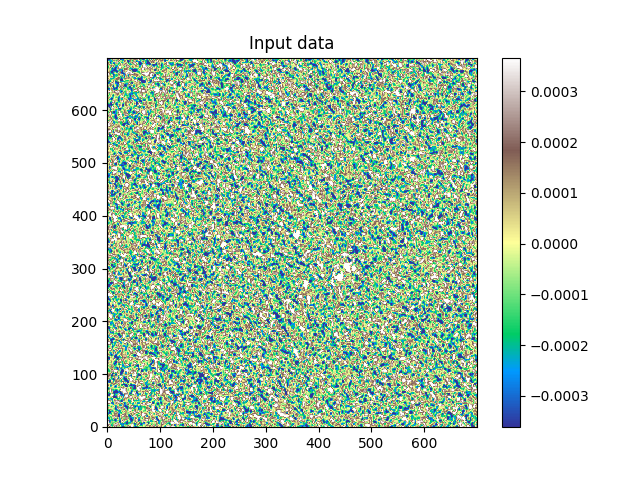

In [4]:
# fig, ax = fm.select('data', nrows=1, ncols=3, sharex=True, sharey=True, figsize=(10, 3))
#fig, ax = fm.select('data')
plt.close('data')
fig = plt.figure('data')
ax = fig.subplots()

im = ax.imshow(data,
               interpolation='nearest', origin='lower', cmap='terrain',
               vmin=np.nanpercentile(data, 5), vmax=np.nanpercentile(data, 95),
              )
ax.set_title('Input data')
cb = fig.colorbar(im, ax=ax)

## Find threshold

### cumulative mass:

In [5]:
sorted_by_data = np.argsort(data.flatten())
sorted_data = data.flatten()[sorted_by_data]

Allow for statistical weights:

In [6]:
weights = np.ones_like(data)
sorted_weight = weights.flatten()[sorted_by_data]

In [7]:
cumulative_mass = np.nancumsum(sorted_weight)
sorted_weight /= cumulative_mass[-1]
cumulative_mass /= cumulative_mass[-1]

### density peak (mode of the probability distribution):
Here we have a couple of free parameters:

In [8]:
delta = .5  # relative size of the smoothing kernel (delta <= 1)

# mass fractions to be tested:
m = np.linspace(delta**2,  # somewhat arbitrary :^(
                1/(1+delta),  # do not overshoot
                int(np.sqrt(data.size)) # a reasonable number of trials
               )

Find maximum:

In [9]:
x_top = np.interp((1+delta)*m, cumulative_mass, sorted_data)
x_mid = np.interp(m, cumulative_mass, sorted_data)
x_bot = np.interp((1-delta)*m, cumulative_mass, sorted_data)
rho_top = delta * m / (x_top - x_mid)
rho_bot = delta * m / (x_mid - x_bot)
peak = np.nanargmin((rho_top - rho_bot) ** 2)
data_mode = x_mid[peak]

m_background = 2 * m[peak]
m_signal = 1 - m_background
threshold_guess = np.interp(m_background, cumulative_mass, sorted_data)

### purity:

In [10]:
m_above = 1 - cumulative_mass
m_symmetric_above = np.interp(2 * data_mode - sorted_data, sorted_data, cumulative_mass, left=0.)
left = np.where(sorted_data < data_mode)
m_symmetric_above[left] = m_background - cumulative_mass[left]
m_signal_above = m_above - m_symmetric_above
purity = m_signal_above / (m_above+1e-30)
purity[-1] = 1

### results:

In [11]:
print(f'data_mode = {data_mode}')
print(f'threshold_guess = {threshold_guess}, m_signal = {m_signal}')

data_mode = -2.981189221007796e-06
threshold_guess = 0.000523295722409473, m_signal = 0.010014306151645225


Text(0.5, 1.0, 'delta = 0.5')

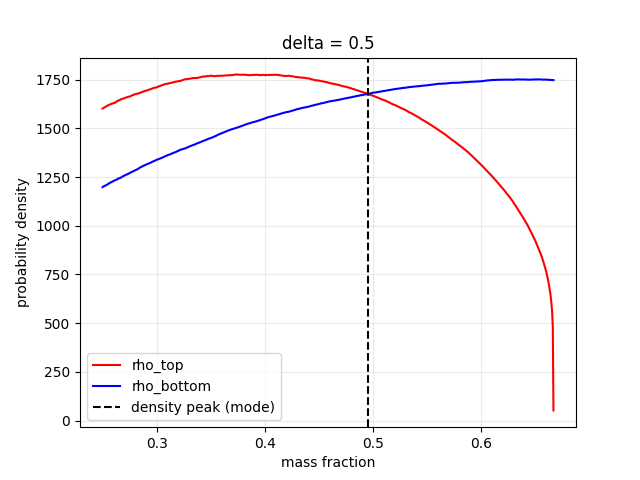

In [12]:
plt.close('density')
fig = plt.figure('density')
ax = fig.subplots()

ax.plot(m, rho_top, 'r-', label='rho_top')
ax.plot(m, rho_bot, 'b-', label='rho_bottom')
ax.axvline(m[peak], c='k', ls='--', label='density peak (mode)')

ax.grid(alpha=.25)
ax.legend()
ax.set_xlabel('mass fraction')
ax.set_ylabel('probability density')
ax.set_title(f'delta = {delta}')

(-0.0009640190401114523, 0.0019190945125598814)

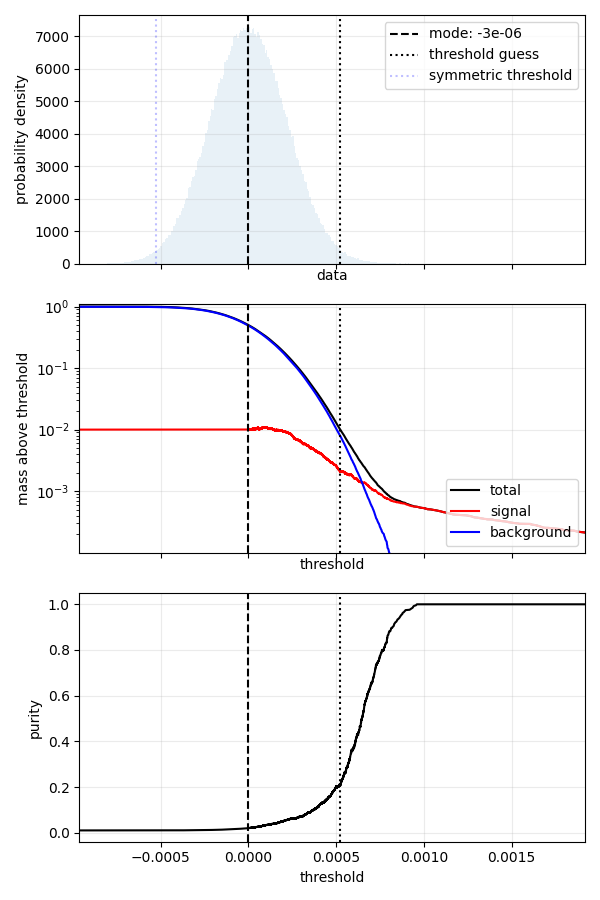

In [13]:
L = max(data_mode-sorted_data[0], threshold_guess-data_mode)

plt.close('statistics')
fig = plt.figure('statistics', figsize=(6, 9))
fig.set_tight_layout(True)
ax = fig.subplots(nrows=3, sharex=True)

# density:

ax[0].hist(sorted_data, bins=np.linspace(sorted_data[0], data_mode + 5*L, int(np.sqrt(data.size))), alpha=.1)
ax[0].axvline(data_mode, c='k', ls='--', label=f'mode: {data_mode:.2g}')
ax[0].axvline(threshold_guess, c='k', ls=':', label='threshold guess')
ax[0].axvline(2*data_mode-threshold_guess, c='b', ls=':', alpha=.25, label='symmetric threshold')

ax[0].grid(alpha=.25)
ax[0].legend()
ax[0].set_xlabel('data')
ax[0].set_ylabel('probability density')

# mass:

ax[1].plot(sorted_data, m_above, 'k-', label='total')
ax[1].plot(sorted_data, m_signal_above, 'r-', label='signal')
ax[1].plot(sorted_data, m_symmetric_above, 'b-', label='background')
ax[1].axvline(data_mode, c='k', ls='--')
ax[1].axvline(threshold_guess, c='k', ls=':')

ax[1].grid(alpha=.25)
ax[1].legend(loc='lower right')
ax[1].set_xlabel('threshold')
#ax[1].set_xlim(sorted_data[0], data_mode + 5*L)
ax[1].set_ylabel('mass above threshold')
ax[1].set_yscale('log')
ax[1].set_ylim(1e-2*m_signal, 1.1)

# purity:

ax[2].plot(sorted_data, purity, 'k-')
ax[2].axvline(data_mode, c='k', ls='--')
ax[2].axvline(threshold_guess, c='k', ls=':')

ax[2].grid(alpha=.25)
#ax[2].legend()
ax[2].set_xlabel('threshold')
ax[2].set_ylabel('purity')

ax[0].set_xlim(sorted_data[0], data_mode + 2*L)

## Hierarchical Overdensity Tree (HOT)

### routine definition:

In [14]:
@njit
def hot(data, threshold, weight):
    parent = -np.ones(data.size, dtype=np.int64)
    area = np.zeros(data.size, dtype=np.int64)
    signal = np.zeros(data.size)

    for pixel in np.argsort(data.flatten())[::-1]:  # decreasing order
        row = pixel // data.shape[0]
        col = pixel % data.shape[0]
        if data[row, col] < threshold:
            break
        row0 = max(row-1, 0)
        row1 = min(row+2, data.shape[0])
        col0 = max(col-1, 0)
        col1 = min(col+2, data.shape[1])
        neighbour_parents = []
        for r in range(row0, row1):
            for c in range(col0, col1):
                p = parent[r*data.shape[0]+c]
                while p > -1:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > -1 and p not in neighbour_parents:
                    neighbour_parents.append(p)

        neighbour_parents = np.array(neighbour_parents)
        n_parents = neighbour_parents.size
        if n_parents == 0:
            selected_parent = pixel
        elif n_parents == 1:
            selected_parent = neighbour_parents[0]
        else:
            #selected_parent = top[neighbour_parents[np.argmax(area[neighbour_parents])]]
            selected_parent = neighbour_parents[np.argmax(area[neighbour_parents])]
            for p in neighbour_parents:
                if p != selected_parent:
                    parent[p] = selected_parent
                    #area[selected_parent] += area[p]
                    #signal[selected_parent] += signal[p]
    #        print(selected_parent)

        #parent[pixel] = top[pixel] = selected_parent
        parent[pixel] = selected_parent
        area[selected_parent] += 1
        signal[selected_parent] += weight[row, col]
    
    parent_list = np.unique(parent)[1:]  # exclude '-1'
    print(f'{len(parent_list)} peaks found')
    if 0 in parent_list:
        p0 = np.where(parent == 0)
        print(f'Bad luck: 0 was an one of them, with {area[0]} ({len(p0[0])}) pixels:')
        print(p0[0])
        new_parent = np.max(p0[0])
        parent[p0] = new_parent
        signal[new_parent] = signal[0]
        area[new_parent] = area[0]
        signal[0] = 0
        print(f'They have been reassigned to label {new_parent}')

    p0 = np.where(parent == -1)  # set background label to 0 instead of -1 (required by SegmentationImage)
    area[0] = len(p0[0])
    parent[p0] = 0

    signal_map = signal[parent]
    signal_map[parent_list] = signal[parent_list]
    area_map = area[parent]
    area_map[parent_list] = area[parent_list]
    return parent, area_map, signal_map

In [15]:
def mode_filter(data):
    neighbours = np.stack([data for _ in range(9)])
    neighbours[1, 1:, 1:] = data[:-1, :-1] # top left
    neighbours[2, 1:, :] = data[:-1, :] # top
    neighbours[3, 1:, :-1] = data[:-1, 1:] # top right
    neighbours[4, :, 1:] = data[:, :-1] # left
    neighbours[5, :, :-1] = data[:, 1:] # right
    neighbours[6, :-1, 1:] = data[1:, :-1] # bottom left
    neighbours[7, :-1, :] = data[1:, :] # bottom
    neighbours[8, :-1, :-1] = data[1:, 1:] # bottom right
    return stats.mode(neighbours, axis=0).mode[0]

### normal and inverted images:

In [16]:
#signal_map = weights*purity.reshape(data.shape)*(data-data_mode)/(threshold_guess-data_mode)
signal_map = weights*((data-data_mode)/(threshold_guess-data_mode))**2
parent, area, signal = hot(data-data_mode, 0, signal_map)
parent_list = np.unique(parent)[1:]  # exclude '-1'
parent_map = segm.SegmentationImage(parent.reshape(data.shape))
'''
top_map = np.array(top).reshape(data.shape)
if 0 in parent_list:
    p = np.where(top == 0)
    print(f'Bad luck: 0 was an object with {area[0]} ({len(p[0])}) particles:')
    print(p[0])
    top_map[p] = np.max(p[0])
    print(f'They have been reassigned to object {np.max(p[0])}')
p = np.where(top_map == -1)  # set background label to 0 instead of -1 (required by SegmentationImage)
top_map[p] = 0
top_map = segm.SegmentationImage(top_map)
'''

avg_signal = (signal/(area+1e-30))
parent_list = np.unique(parent)[1:]  # exclude '-1'
parent_area = area[parent_list]
parent_signal = signal[parent_list]
parent_avg_signal = avg_signal[parent_list]

6531 peaks found


In [17]:
'''
mode_map = np.copy(parent.reshape(data.shape))
while True:
    m = mode_filter(mode_map)
    std = np.std(m-mode_map)
    mode_map = m
    print(f'{len(np.unique(mode_map))} regions; {std}')
    if std < .5:
        break
mode_map = segm.SegmentationImage(mode_map)
'''

"\nmode_map = np.copy(parent.reshape(data.shape))\nwhile True:\n    m = mode_filter(mode_map)\n    std = np.std(m-mode_map)\n    mode_map = m\n    print(f'{len(np.unique(mode_map))} regions; {std}')\n    if std < .5:\n        break\nmode_map = segm.SegmentationImage(mode_map)\n"

In [18]:
#signal_map = weights*(1-purity.reshape(data.shape))*(data_mode-data)/(threshold_guess-data_mode)
signal_map_inv = weights*((data_mode-data)/(threshold_guess-data_mode))**2
parent_inv, area_inv, signal_inv = hot(data_mode-data, 0, signal_map_inv)

avg_signal_inv = (signal_inv/(area_inv+1e-30))
parent_inv_list = np.unique(parent_inv)
parent_inv_area = area_inv[parent_inv_list]
parent_inv_signal = signal_inv[parent_inv_list]
parent_inv_avg_signal = avg_signal_inv[parent_inv_list]

6496 peaks found
Bad luck: 0 was an one of them, with 3 (4) pixels:
[  0   1   2 700]
They have been reassigned to label 700


### selection criterion:

In [19]:
mu_bg = np.nanmean(signal_map_inv[data<data_mode])
avg = parent_inv_signal/parent_inv_area
size_bg_th = np.max(parent_inv_area[avg >= min(1, np.max(avg))])
size_bg_mu = np.max(parent_inv_area[avg > mu_bg])

selection = avg_signal > mu_bg
selection &= area > size_bg_th
selection &= avg_signal > 1 + (mu_bg-1)*(area-size_bg_th)/(size_bg_mu-size_bg_th)

selection = selection[parent]

In [20]:
np.count_nonzero(avg_signal[selection] < mu_bg)

44

In [21]:
selected_map = np.copy(parent)
selected_parents = parent_list[selection[parent_list]]
if 0 in selected_parents:
    p0 = np.where(parent == 0)
    print(f'Bad luck: 0 was an object with {area[0]} ({len(p0[0])}) particles:')
    print(p0[0])
    new_parent = np.max(p0[0])
    selected_map[p0] = new_parent
    selection[new_parent] = True
    print(f'They have been reassigned to object {new_label}')

'''
rejected_parents = parent_list[selection[parent_list] == False]
print(f'{len(selected_parents)} candidates selected and {len(rejected_parents)} recjected among {len(parent_list)}')

adoptive_parents = parent[rejected_parents]
while True:
    orphan_list = np.where(selection[adoptive_parents] == False)
    #print(f'{len(orphan_list[0])} orphans')
    orphan_parent = adoptive_parents[orphan_list]
    orphan_grandparent = parent[orphan_parent]
    still_looking = np.where(np.not_equal(orphan_grandparent, orphan_parent))
    if len(still_looking[0]) > 0:
        orphan_parent[still_looking] = orphan_grandparent[still_looking]
        adoptive_parents[orphan_list] = orphan_parent
    else:
        break
print(f'{len(orphan_list[0])} candidates merged into the background')

# TODO: speed this up :^(
selected_map[parent_list] = parent_list  # relabel "central" pixel, pointing to "parent"
for r, rejected in enumerate(rejected_parents):
    pixels = np.where(parent == rejected)
    new_parent = adoptive_parents[r]
    if selection[new_parent]:
        selected_map[pixels] = new_parent
    else:
        selected_map[pixels] = -1
'''

p0 = np.where(selected_map == -1)  # set background label to 0 instead of -1 (required by SegmentationImage)
selected_map[p0] = 0
selected_map[selection[selected_map] == False] = 0

selected_map = segm.SegmentationImage(selected_map.reshape(data.shape))

In [22]:
np.unique(selected_map)

array([     0, 128620, 132023, 141824, 164951, 166321, 171236, 171267,
       175442, 180324, 180332, 182370, 185263, 185876, 186583, 188727,
       189441, 190145, 193664, 195749, 196368, 197840, 197855, 197867,
       198532, 199165, 203428, 203450, 204144, 204174, 204767, 206153,
       206259, 209047, 210466, 212554, 213935, 214602, 216074, 217461,
       218825, 219491, 219511, 220242, 220252, 221666, 225130, 229348,
       232781, 234161, 234236, 234944, 234958, 238394, 241858, 241869,
       241877, 241963, 243950, 245397, 246855, 247453, 249649, 250328,
       250968, 253755, 253806, 261450, 262216, 264213, 266388, 269851,
       270568, 274763, 280320, 293664, 296477, 297116, 302066, 305541,
       314639, 316723, 323011, 325038, 387372, 388056, 392250, 395043,
       395756, 398551])

### results:

NameError: name 'mode_map' is not defined

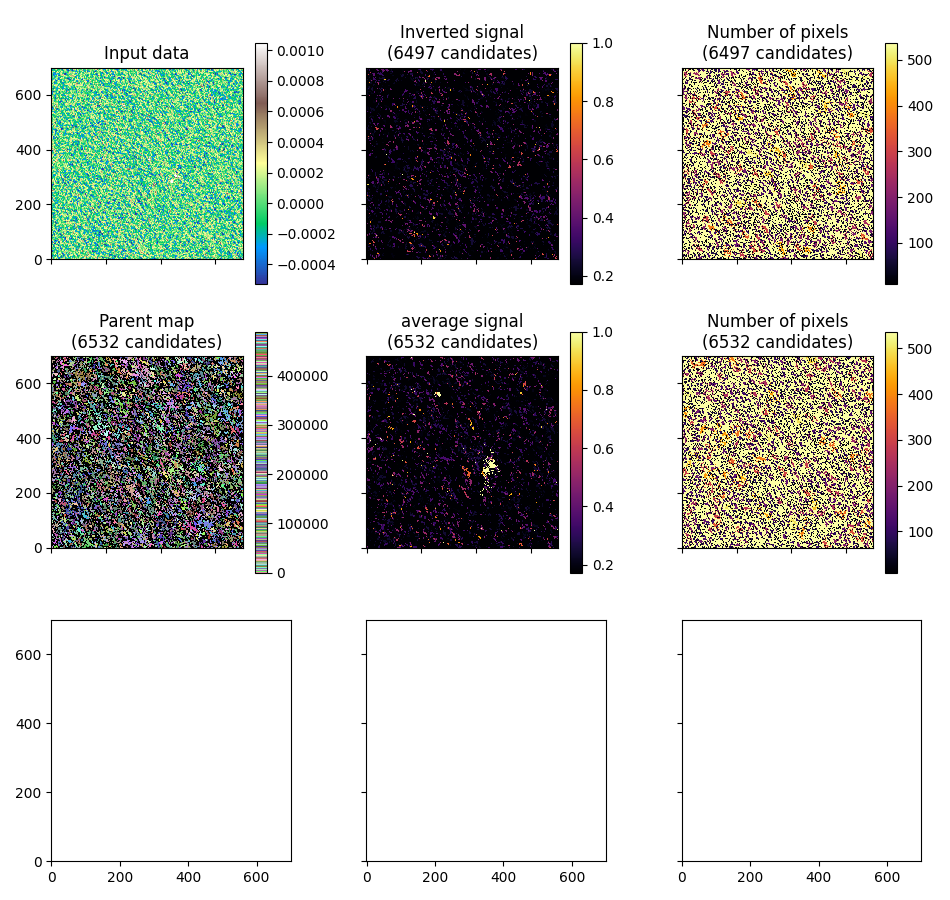

In [24]:
#'''
plt.close('HOT maps')
fig = plt.figure('HOT maps', figsize=(9.5, 9))
fig.set_tight_layout(True)
ax = fig.subplots(nrows=3, ncols=3, sharex=True, sharey=True)

ax[0, 0].set_title('Input data')
im = ax[0, 0].imshow(
    data,
    interpolation='nearest', origin='lower', cmap='terrain',
#    vmin=-2, vmax=2,
    vmin=2*data_mode-threshold_guess, vmax=2*threshold_guess-data_mode,
    )
cb = fig.colorbar(im, ax=ax[0, 0])

ax[0, 1].set_title(f'Inverted signal\n({len(np.unique(parent_inv))} candidates)')
im = ax[0, 1].imshow(
    avg_signal_inv.reshape(data.shape),
    interpolation='nearest', origin='lower', cmap='inferno',
    vmin=mu_bg, vmax=1,
    )
cb = fig.colorbar(im, ax=ax[1, 1])

ax[0, 2].set_title(f'Number of pixels\n({len(np.unique(parent_inv))} candidates)')
im = ax[0, 2].imshow(
    area_inv.reshape(data.shape),
    #np.log10(area_inv+1).reshape(data.shape),
    interpolation='nearest', origin='lower', cmap='inferno',
    vmin=size_bg_th, vmax=size_bg_mu,
    )
cb = fig.colorbar(im, ax=ax[1, 2])


ax[1, 0].set_title(f'Parent map\n({len(np.unique(parent))} candidates)')
im = ax[1, 0].imshow(
    parent_map,
    interpolation='nearest', origin='lower', cmap=parent_map.make_cmap(seed=123),
    )
cb = fig.colorbar(im, ax=ax[1, 0])
'''
ax[1, 0].set_title('Final selection')
im = ax[1, 0].imshow(
#    signal_map_inv,
    selection.reshape(data.shape),
    interpolation='nearest', origin='lower', cmap='terrain',
    #vmin=-2, vmax=2,
    )
cb = fig.colorbar(im, ax=ax[1, 0])
'''

ax[1, 1].set_title(f'average signal\n({len(np.unique(parent))} candidates)')
im = ax[1, 1].imshow(
    avg_signal.reshape(data.shape),
    interpolation='nearest', origin='lower', cmap='inferno',
    vmin=mu_bg, vmax=1,
    )
cb = fig.colorbar(im, ax=ax[0, 1])

ax[1, 2].set_title(f'Number of pixels\n({len(np.unique(parent))} candidates)')
im = ax[1, 2].imshow(
#    np.log10(area+1).reshape(data.shape),
    area.reshape(data.shape),
    interpolation='nearest', origin='lower', cmap='inferno',
    vmin=size_bg_th, vmax=size_bg_mu,
    )
cb = fig.colorbar(im, ax=ax[0, 2])

ax[2, 0].set_title(f'Median map\n({len(mode_map.labels)} candidates)')
im = ax[2, 0].imshow(
    mode_map,
    interpolation='nearest', origin='lower', cmap=mode_map.make_cmap(seed=123),
    )
cb = fig.colorbar(im, ax=ax[2, 0])

#'''

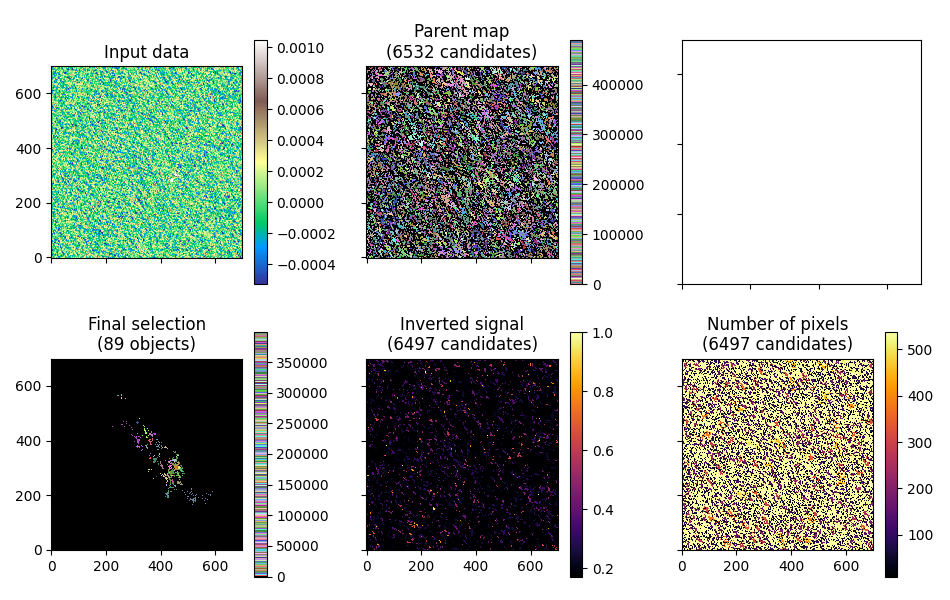

In [25]:
plt.close('HOT genealogy')
fig = plt.figure('HOT genealogy', figsize=(9.5, 6))
fig.set_tight_layout(True)
ax = fig.subplots(nrows=2, ncols=3, sharex=True, sharey=True)

ax[0, 0].set_title('Input data')
im = ax[0, 0].imshow(
    data,
    interpolation='nearest', origin='lower', cmap='terrain',
#    vmin=-2, vmax=2,
    vmin=2*data_mode-threshold_guess, vmax=2*threshold_guess-data_mode,
    )
cb = fig.colorbar(im, ax=ax[0, 0])

ax[0, 1].set_title(f'Parent map\n({len(np.unique(parent))} candidates)')
im = ax[0, 1].imshow(
    parent_map,
    interpolation='nearest', origin='lower', cmap=parent_map.make_cmap(seed=123),
    )
cb = fig.colorbar(im, ax=ax[0, 1])

'''
ax[0, 2].set_title(f'Top map\n({len(np.unique(top))} candidates)')
im = ax[0, 2].imshow(
    top_map,
    interpolation='nearest', origin='lower', cmap=top_map.make_cmap(seed=123),
    )
cb = fig.colorbar(im, ax=ax[0, 2])
'''

ax[1, 0].set_title(f'Final selection\n({np.count_nonzero(selection[parent_list])} objects)')
im = ax[1, 0].imshow(
#    signal_map_inv,
#    selection.reshape(data.shape),
#    interpolation='nearest', origin='lower', cmap='terrain',
    selected_map,
    interpolation='nearest', origin='lower', cmap=selected_map.make_cmap(seed=123),
    #vmin=-2, vmax=2,
    )
cb = fig.colorbar(im, ax=ax[1, 0])

ax[1, 1].set_title(f'Inverted signal\n({len(np.unique(parent_inv))} candidates)')
im = ax[1, 1].imshow(
    avg_signal_inv.reshape(data.shape),
    interpolation='nearest', origin='lower', cmap='inferno',
    vmin=mu_bg, vmax=1,
    )
cb = fig.colorbar(im, ax=ax[1, 1])

ax[1, 2].set_title(f'Number of pixels\n({len(np.unique(parent_inv))} candidates)')
im = ax[1, 2].imshow(
    area_inv.reshape(data.shape),
    #np.log10(area_inv+1).reshape(data.shape),
    interpolation='nearest', origin='lower', cmap='inferno',
    vmin=size_bg_th, vmax=size_bg_mu,
    )
cb = fig.colorbar(im, ax=ax[1, 2])

(0.0, 2.0)

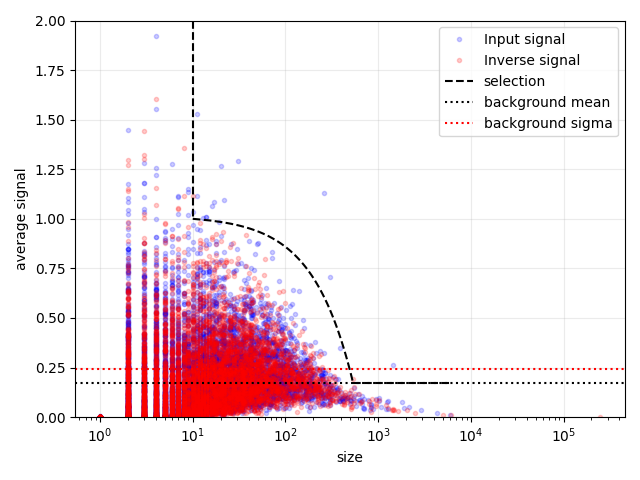

In [26]:
plt.close('selection')
fig = plt.figure('selection')
fig.set_tight_layout(True)
ax = fig.subplots()

ax.plot(parent_area, parent_signal/parent_area, 'b.', alpha=0.2, label='Input signal')
ax.plot(parent_inv_area, parent_inv_signal/parent_inv_area, 'r.', alpha=0.2, label='Inverse signal')

aa = np.linspace(size_bg_th, size_bg_mu, 101)
ss = 1 + (mu_bg-1)*(aa-size_bg_th)/(size_bg_mu-size_bg_th)

ax.plot([size_bg_th, size_bg_th], [np.nanmax(parent_signal/parent_area), 1], 'k--')
ax.plot(aa, ss, 'k--', label='selection')
ax.plot([size_bg_mu, np.max(parent_area)], [mu_bg, mu_bg], 'k--')

ax.axhline(mu_bg, c='k', ls=':', label='background mean')
ax.axhline(np.nanstd(signal_map_inv[data<data_mode]), c='r', ls=':', label='background sigma')
#aa = np.logspace(0, 3)
#ss = np.nanstd(signal_map_inv[data<data_mode]) * np.power(aa, .5)
#ax.plot(aa, mu+ss/aa, 'k:')
#ax.plot(aa, mu-ss/aa, 'k:')

ax.grid(alpha=.25)
ax.legend(loc='upper right')
ax.set_xlabel('size')
ax.set_xscale('log')
ax.set_ylabel('average signal')
#ax.set_yscale('log')
#ax.set_ylim(0.1*mu_bg, np.nanmax(parent_signal/parent_area))
ax.set_ylim(0, 2)

Text(0, 0.5, 'number of pixels')

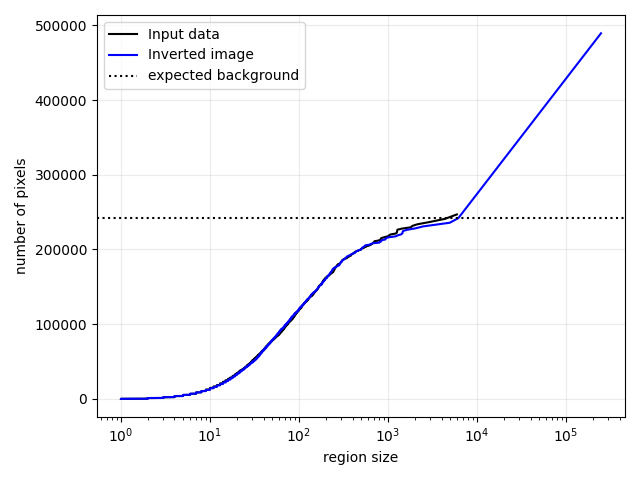

In [27]:
plt.close('region size')
fig = plt.figure('region size')
fig.set_tight_layout(True)
ax = fig.subplots()

sorted_area = np.sort(parent_area)
sorted_area_inv = np.sort(parent_inv_area)
ax.plot(sorted_area, np.cumsum(sorted_area), 'k-', label='Input data')
ax.plot(sorted_area_inv, np.cumsum(sorted_area_inv), 'b-', label='Inverted image')
ax.axhline((m_background/2)*data.size, c='k', ls=':', label='expected background')

ax.grid(alpha=.25)
ax.legend()
ax.set_xlabel('region size')
ax.set_xscale('log')
ax.set_ylabel('number of pixels')
#ax.set_yscale('log')

In [ ]:
len(parent_area)

In [ ]:
plt.close('region signal')
fig = plt.figure('region signal')
fig.set_tight_layout(True)
ax = fig.subplots()

sorted_avg = np.sort(parent_signal/parent_area)
sorted_avg_inv = np.sort(parent_inv_signal/parent_inv_area)
ax.plot(sorted_avg, np.arange(sorted_avg.size)+1, 'k-', label='Input data')
ax.plot(sorted_avg_inv, np.arange(sorted_avg_inv.size)+1, 'b-', label='Inverted image')
ax.axvline(mu_bg, c='k', ls=':', label='expected background')

ax.grid(alpha=.25)
ax.legend()
ax.set_xlabel('average signal')
ax.set_xscale('log')
ax.set_ylabel('number of regions')
#ax.set_yscale('log')